#### Business Problem
- Which product categories has lower reviews?
- Which product categories has higher reviews?
 

#### Business solutions:
- By using Sentiment analysis, can we predict scores for reviews based on certain words

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
df = pd.read_csv('data/Amazon Reviews.csv')
df.head(1).transpose()

,0
id,AVqkIhwDv8e3D1O-lebb
name,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,..."
asins,B01AHB9CN2
brand,Amazon
categories,"Electronics,iPad & Tablets,All Tablets,Fire Ta..."
keys,"841667104676,amazon/53004484,amazon/b01ahb9cn2..."
manufacturer,Amazon
reviews.date,2017-01-13T00:00:00.000Z
reviews.dateAdded,2017-07-03T23:33:15Z
reviews.dateSeen,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z"


In [3]:
reviews_df = df
reviews_df.shape

(34660, 21)

Dataset size : 34,660 rows and 17 columns

Assumptions:
- Reviews rating < 4 is negative. Rating >=4 is positive
- Sample size of 30K examples are sufficient to represent the entire population of sales/reviews
- The text reviews of each product will be rich enough to train a sentiment analysis classifier 

In [4]:
reviews_df.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

- `reviews.rating` type is float (will convert into int)
- `reviews.userCity`, `reviews.userProvince`, `reviews.id`, and `reviews.didPurchase`types are float (check more into this)

In [6]:
reviews_df[['reviews.userCity', 'reviews.userProvince', 'reviews.id', 'reviews.didPurchase']]

,reviews.userCity,reviews.userProvince,reviews.id,reviews.didPurchase
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
34655,NaN,NaN,NaN,NaN
34656,NaN,NaN,NaN,NaN
34657,NaN,NaN,NaN,NaN
34658,NaN,NaN,NaN,NaN


Drop these columns because almost 100% are `NaN` values

In [7]:
reviews_df = reviews_df.drop(columns=['reviews.userCity', 'reviews.userProvince', 
                                      'reviews.id', 'reviews.didPurchase'],
                            axis=1)

In [8]:
reviews_df.isnull().sum()

id                         0
name                    6760
asins                      2
brand                      0
categories                 0
keys                       0
manufacturer               0
reviews.date              39
reviews.dateAdded      10621
reviews.dateSeen           0
reviews.doRecommend      594
reviews.numHelpful       529
reviews.rating            33
reviews.sourceURLs         0
reviews.text               1
reviews.title              5
reviews.username           2
dtype: int64

<br>


### Data Exploration

- `name` and `asins`

In [9]:
# list all 'asins' and name of the 'asins'

reviews_df.groupby('asins')['name'].unique()

asins
B002Y27P3M               [Kindle Keyboard,,,\r\nKindle Keyboard,,,, All...
B002Y27P6Y                                                           [nan]
B005PB2T0S               [Amazon Kindle Lighted Leather Cover,,,\r\nAma...
B005PB2T2Q               [Fire Kids Edition Tablet, 7 Display, Wi-Fi, 1...
B006GWO5NE                                                           [nan]
B006GWO5WK                                                           [nan]
B0083Q04TA               [Fire Tablet, 7 Display, Wi-Fi, 8 GB - Include...
B00BFJAHF8                                                           [nan]
B00DU15MU4               [Brand New Amazon Kindle Fire 16gb 7 Ips Displ...
B00IOY8XWQ               [Kindle Voyage E-reader, 6 High-Resolution Dis...
B00IOYAM4I               [Brand New Amazon Kindle Fire 16gb 7 Ips Displ...
B00L9EPT8O,B01E6AO69U    [Echo (White),,,\r\nEcho (White),,,, Echo (Whi...
B00LO29KXQ               [Fire Tablet, 7 Display, Wi-Fi, 8 GB - Include...
B00LW9XOJM         

In [10]:
len(reviews_df.groupby('asins')['name'].unique())

41

Note: there are actually 41 `asins` with one of the product having 2 `asins`

In [11]:
# Lets see all the different names for this product that have 2 'asins'

names_df = pd.DataFrame(reviews_df[reviews_df['asins']=='B00L9EPT8O,B01E6AO69U']['name'].value_counts())
names_df = names_df.rename(columns={"name": " value counts"})
names_df

,value counts
"Echo (White),,,\r\nEcho (White),,,",2898
"Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",2527
"Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,\r\nAmazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,,,",318
"Amazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,\r\nAmazon Fire Hd 10 Tablet, Wi-Fi, 16 Gb, Special Offers - Silver Aluminum,,,",128
"Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,",36
"Kindle Dx Leather Cover, Black (fits 9.7 Display, Latest and 2nd Generation Kindle Dxs),,",9
"Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,",7
"New Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable,,,\r\nNew Amazon Kindle Fire Hd 9w Powerfast Adapter Charger + Micro Usb Angle Cable,,,",6
"Amazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,\r\nAmazon Fire Hd 6 Standing Protective Case(4th Generation - 2014 Release), Cayenne Red,,,",6
"Amazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,\r\nAmazon Kindle Fire 5ft USB to Micro-USB Cable (works with most Micro-USB Tablets),,,",4


Based on the exploration above :
- each `asins` can have multiple names (There is 1-to-many relationship between `asins` and `name`)
- `asins` is more important than `name` for the business problem

In [12]:
# reviews_df['name'].fillna('0', inplace=True)

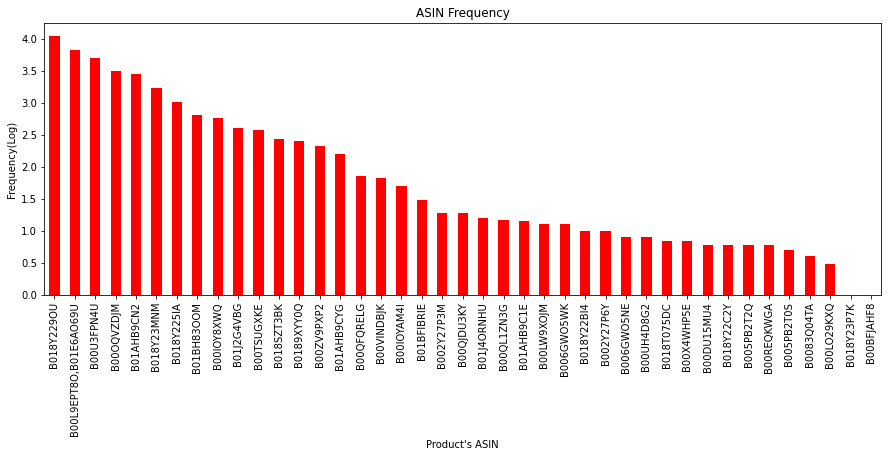

In [13]:
fig = plt.figure(figsize=(15,5))
np.log10(reviews_df["asins"].value_counts()).plot(kind="bar", 
                                                  title="ASIN Frequency", color='red') 
plt.xlabel("Product's ASIN")
plt.ylabel('Frequency(Log)')
plt.show()

Based on the exploration above:
- `asins` has a right-skewed distribution, means that certain products have significantly more reviews than other products, which may indicate a higher sale in those specific products

In [14]:
# reviews_df['reviews.rating'].isna().sum()

<br>
<br>

- `reviews.doRecommend`

<AxesSubplot:xlabel='reviews.doRecommend', ylabel='count'>

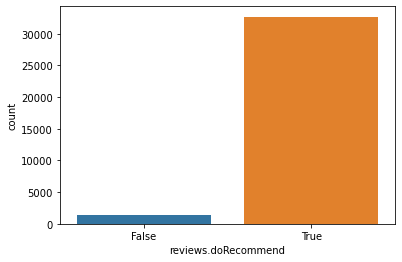

In [15]:
sns.countplot(reviews_df['reviews.doRecommend'])

In [16]:
reviews_df['reviews.doRecommend'].value_counts()

True     32682
False     1384
Name: reviews.doRecommend, dtype: int64

<br>

- `reviews.numHelpful`

In [17]:
numeric_df = reviews_df._get_numeric_data()
numeric_df.columns

Index(['reviews.numHelpful', 'reviews.rating'], dtype='object')

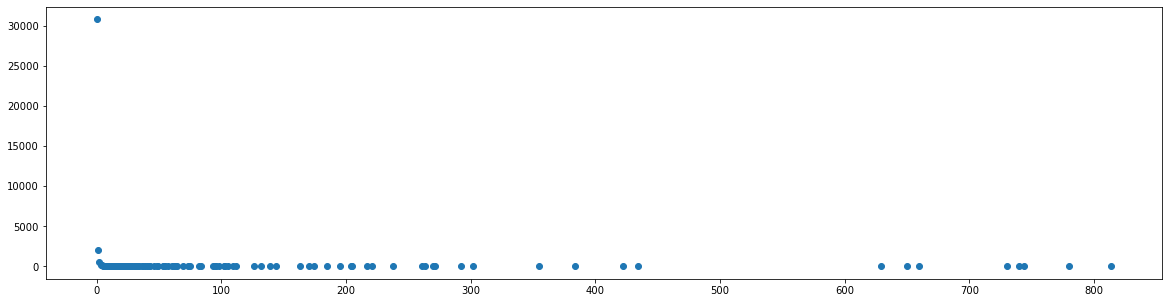

In [18]:
# visualization for reviews.numHelpful

plt.figure(figsize=(20,5))
plt.scatter(numeric_df['reviews.numHelpful'].value_counts().index,
           numeric_df['reviews.numHelpful'].value_counts().values)
plt.show()


Based on the distributions above:

- `reviews.numHelpful`: Outliers in this case are valuable, so we may want to weight reviews that had more than 50+ people who find them helpful
<br>
<br>


<br>

- `reviews.text`

In [19]:
reviews_df[reviews_df['reviews.text'].isna()]['reviews.rating']

3111    5.0
Name: reviews.rating, dtype: float64

In [20]:
reviews_df['reviews.text'].fillna(' ', inplace=True)

In [21]:
# reviews_df.isna().sum()

<br>

<br>

#### Explore target columns `reviews.rating`

In [22]:
reviews_df['reviews.rating'].isna().sum()

33

In [23]:
# drop this null values from col 'reviews.rating'
reviews_df['reviews.rating'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
34655    False
34656    False
34657    False
34658    False
34659    False
Name: reviews.rating, Length: 34660, dtype: bool

In [24]:
reviews_df['reviews.rating'].mean()

4.584572732260953

In [25]:
reviews_df['reviews.rating'].median()

5.0

In [26]:
# change review.rating data type 
reviews_df['reviews.rating'] = round(reviews_df['reviews.rating'])
reviews_df['reviews.rating'].values

array([5., 5., 5., ..., 1., 1., 1.])

In [27]:
# drop the null values from column 'reviews.rating'
reviews_df = reviews_df[reviews_df['reviews.rating'].notna()]

<AxesSubplot:xlabel='reviews.rating', ylabel='count'>

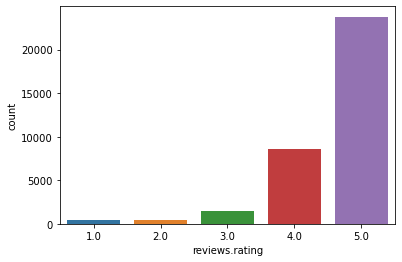

In [28]:
sns.countplot(reviews_df['reviews.rating'])

- `reviews.rating`: Majority of examples were rated highly (looking at rating distribution). There is twice amount of 5 star ratings than the others ratings combined <br>
Assumption:
- `reviews.rating` that are below 4 should be encoded as 0 ('not good') and `reviews.rating` with scores 4 and 5 as 1 ('good').

In [29]:
reviews_df["reviews.rating"] = reviews_df["reviews.rating"].apply(lambda x: 0 if x < 4 else 1)

# reviews_df['reviews.rating'] = reviews_df["reviews.rating"].apply( 
#     lambda x: 1 if x >=4 else 0 if x ==3 else -1)
# reviews_df['reviews.rating'].value_counts()

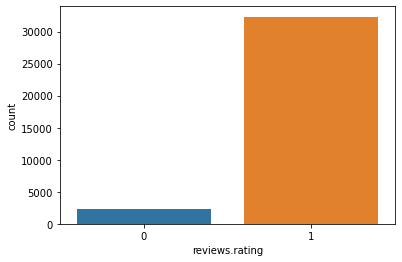

In [30]:
sns_plot = sns.countplot(reviews_df['reviews.rating'])

In [31]:
sns_plot.figure.savefig("reviews_rating.png")

In [32]:
# print("Score negative (%):" + str(round(len(reviews_df[reviews_df['reviews.rating']==-1])/len(reviews_df['reviews.rating']),3)))
print("Score negative (%):" + str(round(len(reviews_df[reviews_df['reviews.rating']==0])/len(reviews_df['reviews.rating']),3)))
print("Score positive (%):" + str(round(len(reviews_df[reviews_df['reviews.rating']==1])/len(reviews_df['reviews.rating']),3)))

Score negative (%):0.067
Score positive (%):0.933


<br>

In [33]:
asins_counts = pd.DataFrame(reviews_df["asins"].value_counts())
avg_rating = reviews_df.groupby("asins")["reviews.rating"].mean()
plot_df = asins_counts.join(avg_rating)
plot_df.head(5)

,asins,reviews.rating
B018Y229OU,10966,0.906620
"B00L9EPT8O,B01E6AO69U",6619,0.951503
B00U3FPN4U,5056,0.958465
B00OQVZDJM,3176,0.972922
B01AHB9CN2,2814,0.947761


,asins,reviews.rating
asins,1.000000,0.152393
reviews.rating,0.152393,1.000000


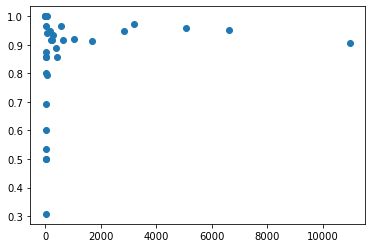

In [34]:
plt.scatter("asins", "reviews.rating", data=plot_df)
plot_df.corr()

From our analysis in data exploration above between ASINs and reviews.rating, we discovered that there are many ASINs with low occurrence that have high variances, as a result we concluded that theses low occurrence ASINs are not significant in our analysis given the low sample size. 

Similarly in our correlation analysis between ASINs and reviews.rating, we see that there is almost no correlation which is consistent with our findings.
<br>
<br>
<br>

-----

#### Cleaning text data

In [35]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string

from nltk.corpus import stopwords 
stemmer = nltk.stem.PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')
ENGLISH_STOP_WORDS.remove('not')
ENGLISH_STOP_WORDS.remove('no')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

<br>
<br>

### Split into Train/Test/Validation

- Since the majority of reviews are good, we will need to do a stratified split on the `reviews score` to ensure that we don’t train the classifier on imbalanced data

In [129]:
X = reviews_df['reviews.text']
y = reviews_df['reviews.rating']

In [130]:
def train_test_split(X,y):
    
    from sklearn.model_selection import train_test_split

    # Taking a chuck for our 20% test set
    X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

    # Splitting the remainder in two chunks
    X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, 
                                                                    y_remainder, 
                                                                    stratify=y_remainder, test_size=0.25)
    from sklearn.feature_extraction.text import CountVectorizer 
    bagofwords = CountVectorizer(tokenizer=my_tokenizer)
    bagofwords.fit(X_train)
    X_train = bagofwords.transform(X_train)
    X_validation = bagofwords.transform(X_validation)
    X_test = bagofwords.transform(X_test)
    X_remainder = bagofwords.transform(X_remainder)
    
    #oversampling the minority class
    
    from imblearn.over_sampling import RandomOverSampler
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    return X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords

In [131]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

In [132]:
X_train.shape

(36354, 10011)

In [133]:
y_train.shape

(36354,)

In [134]:
y_train.value_counts()

1    18177
0    18177
Name: reviews.rating, dtype: int64

In [45]:
# lists for accuracy scores per model
accuracy_sc=[]
modelling=[]

<br>
<br>

## Modelling

### Logistic Regression

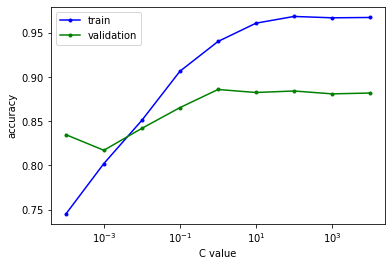

In [46]:
import warnings
warnings.filterwarnings("ignore")


# Now we have our data Vectorized (i.e. a table numerical rows/columns)
# so we can build a model on it
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

train_accs = []
test_accs = []
val_accs = []

for c in C_values:
    
    # Instantiate & fit the model
    logreg = LogisticRegression(C = c)
    logreg.fit(X_train, y_train)
    
    # Keep track of the train & test accuacies
    train_accs.append(logreg.score(X_train, y_train))
    val_accs.append(logreg.score(X_validation,y_validation))

# Visualize the train & test accuracies across c-values
plt.figure()
plt.plot(C_values, train_accs, c='blue', label='train', marker='.')
plt.plot(C_values, val_accs, c='green', label='validation', marker='.')
plt.xlabel('C value')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.show()


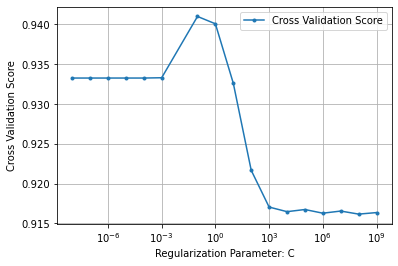

The best model has C =  0.1


In [47]:
# 10-folds cross validation

from sklearn.model_selection import cross_val_score

cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    LR_model = LogisticRegression(C=c,random_state=1)
    cv_score = np.mean(cross_val_score(LR_model, X_remainder, y_remainder, cv = 10))
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

In [48]:
best_log_model = LogisticRegression(C=C_range[which_max])
best_log_model.fit(X_remainder,y_remainder)
print(f'Score on train: {best_log_model.score(X_remainder,y_remainder)}')
print(f'Score on test: {best_log_model.score(X_test,y_test)}')

Score on train: 0.9485945321524837
Score on test: 0.9407415963959801


In [49]:
accuracy_sc.append(best_log_model.score(X_test,y_test))
modelling.append('Logistic Regression')

In [50]:
# Confusion Matrix & Classification Report

from sklearn.metrics import confusion_matrix

y_pred = best_log_model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[ 112,  466],
       [  47, 8032]], dtype=int64)

In [51]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.70      0.19      0.30       578
           1       0.95      0.99      0.97      8079

    accuracy                           0.94      8657
   macro avg       0.82      0.59      0.64      8657
weighted avg       0.93      0.94      0.92      8657



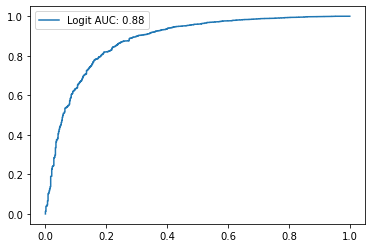

In [52]:
# ROC & AUC

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

best_log_model = LogisticRegression(C=C_range[which_max])
best_log_model.fit(X_remainder,y_remainder)

y_pred = best_log_model.predict_proba(X_test)[:, 1]


logit_fprs_test, logit_tprs_test, thresholds_test = roc_curve(y_test, y_pred)

logit_auc_value = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot(logit_fprs_test, logit_tprs_test, label=f"Logit AUC: {round(logit_auc_value,2)}")
plt.legend()
plt.show()

In [53]:
coefficients = best_log_model.coef_

In [54]:
indices = coefficients.argsort()[0]

In [55]:
# The words with the lowest coefficients 
# most predictive of a 0 (negative review)

np.array(bagofwords.get_feature_names())[indices[:20]]

array(['return', 'slow', 'ok', 'okay', 'hope', 'terribl', 'not',
       'wouldnt', 'disappoint', 'freez', 'noth', 'slower', 'basic',
       'doesnt', 'didnt', 'pay', 'limit', 'die', 'wast', 'decent'],
      dtype='<U87')

In [56]:
strg=''
for word in np.array(bagofwords.get_feature_names())[indices[:20]]:
    strg+=word+" "

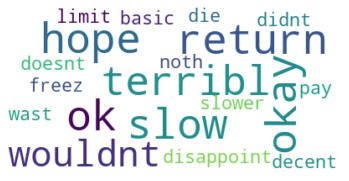

In [57]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(strg)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
# The words with the highest coefficients
# most predictive of a 1 (positive review)
np.array(bagofwords.get_feature_names())[indices[-20:]]

array(['best', 'echo', 'prime', 'cabl', 'conveni', 'room', 'highli',
       'happi', 'well', 'worri', 'beat', 'fun', 'enjoy', 'awesom', 'amaz',
       'great', 'excel', 'easi', 'perfect', 'love'], dtype='<U87')

In [59]:
strg=''
for word in np.array(bagofwords.get_feature_names())[indices[-20:]]:
    strg+=word+" "

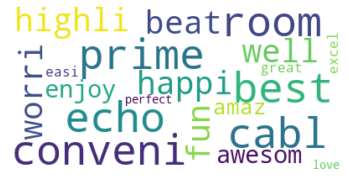

In [60]:

from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(strg)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<br>


### K-Nearest Neighbor

In [61]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

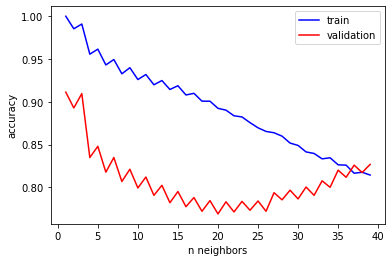

In [62]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier

k_values = np.arange(1,40,1)

train_scores = []
val_scores = []

for k in k_values:
    
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    train_scores.append(knn.score(X_train, y_train))
    val_scores.append(knn.score(X_validation, y_validation))
    

plt.figure()
plt.plot(k_values, train_scores, c='blue', label='train')
plt.plot(k_values, val_scores, c='red', label='validation')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.legend()
plt.show()


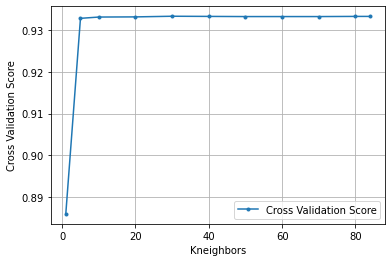

The best model has k =  30


In [63]:
K_range = [1,5,10,20,30,40,50,60,70,80,84]

cross_validation_scores = []

for i in K_range:
    my_model = KNeighborsClassifier(n_neighbors=i)
    
    scores = np.mean(cross_val_score(my_model, X_remainder, y_remainder, cv=10))
    
    cross_validation_scores.append(scores)
    
plt.figure()
plt.plot(K_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('Kneighbors')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has k = ",K_range[which_max])

In [64]:
best_knn_model = KNeighborsClassifier(n_neighbors=K_range[which_max])
best_knn_model = best_knn_model.fit(X_remainder, y_remainder)

train_score = best_knn_model.score(X_remainder,y_remainder)
test_score = best_knn_model.score(X_test, y_test)

In [65]:
print(f'Score on train: {train_score}')
print(f'Score on test: {test_score}')

Score on train: 0.9333076626877166
Score on test: 0.9331177082130068


In [66]:
accuracy_sc.append(test_score)
modelling.append('K Nearest Neighbor')

In [67]:
from sklearn.metrics import confusion_matrix

y_pred = best_knn_model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[   0,  578],
       [   1, 8078]], dtype=int64)

In [68]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.93      1.00      0.97      8079

    accuracy                           0.93      8657
   macro avg       0.47      0.50      0.48      8657
weighted avg       0.87      0.93      0.90      8657



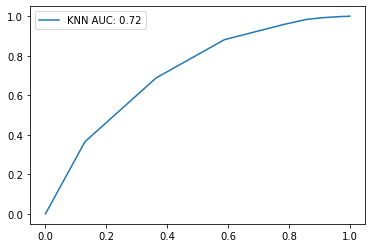

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

best_knn_model = KNeighborsClassifier(n_neighbors=K_range[which_max])
best_knn_model = best_knn_model.fit(X_remainder, y_remainder)

y_pred = best_knn_model.predict_proba(X_test)[:, 1]


knn_fprs_test, knn_tprs_test, thresholds_test = roc_curve(y_test, y_pred)

knn_auc_value = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot(knn_fprs_test, knn_tprs_test, label=f"KNN AUC: {round(knn_auc_value,2)}")
plt.legend()
plt.show()

<br>

### Decision Tree

In [70]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

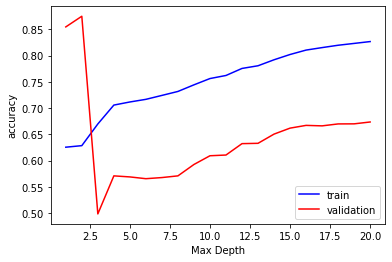

In [71]:
from sklearn.tree import DecisionTreeClassifier

dt_test_accuracies = []
depths = []
train_scores =[]
val_scores =[]
d_values = np.arange(1,21,1)

for d in d_values:

    my_dt = DecisionTreeClassifier(max_depth=d, random_state=1)
    my_dt.fit(X_train, y_train)
    train_scores.append(my_dt.score(X_train, y_train))
    val_scores.append(my_dt.score(X_validation, y_validation))
    depths.append(d)
    
plt.figure()
plt.plot(depths, train_scores, c='blue', label='train')
plt.plot(depths, val_scores, c='red', label='validation')
plt.xlabel('Max Depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()


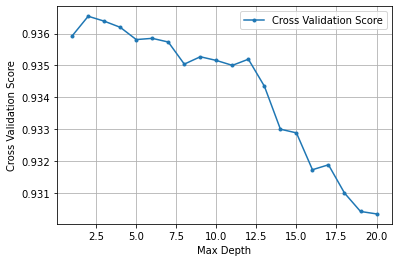

The best model has depth =  2


In [72]:
d_values = np.arange(1,21,1)

cross_validation_scores = []

for d in d_values:
    
    my_dt = DecisionTreeClassifier(max_depth=d, random_state=1)
    
    scores = np.mean(cross_val_score(my_dt, X_remainder, y_remainder, cv=10))
    
    cross_validation_scores.append(scores)
    
plt.figure()
plt.plot(d_values, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has depth = ",d_values[which_max])

In [73]:
best_dt_model = DecisionTreeClassifier(max_depth=d_values[which_max], random_state=1)
best_dt_model = best_dt_model.fit(X_remainder, y_remainder)

train_score = best_dt_model.score(X_remainder,y_remainder)
test_score = best_dt_model.score(X_test, y_test)

print(f'Score on train: {train_score}')
print(f'Score on test: {test_score}')

Score on train: 0.9365421640354255
Score on test: 0.9338107889569135


In [74]:
accuracy_sc.append(test_score)
modelling.append('Decision Tree')

In [75]:
from sklearn.metrics import confusion_matrix

y_pred = best_dt_model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[  44,  534],
       [  39, 8040]], dtype=int64)

In [76]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.53      0.08      0.13       578
           1       0.94      1.00      0.97      8079

    accuracy                           0.93      8657
   macro avg       0.73      0.54      0.55      8657
weighted avg       0.91      0.93      0.91      8657



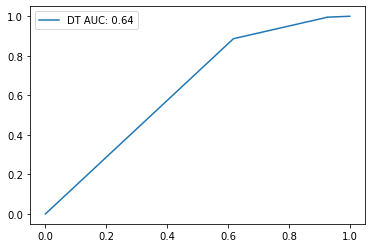

In [77]:
from sklearn.tree import DecisionTreeClassifier

best_dt_model = DecisionTreeClassifier(max_depth=d_values[which_max], random_state=1)
best_dt_model = best_dt_model.fit(X_remainder, y_remainder)

y_pred = best_dt_model.predict_proba(X_test)[:, 1]


dt_fprs_test, dt_tprs_test, thresholds_test = roc_curve(y_test, y_pred)

dt_auc_value = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot(dt_fprs_test, dt_tprs_test, label=f"DT AUC: {round(dt_auc_value,2)}")
plt.legend()
plt.show()

<br>

### Random Forest

In [78]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

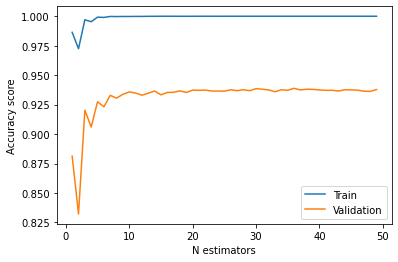

In [79]:
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
val_scores =[]

for n in range(1,50):
    rf = RandomForestClassifier(n_estimators = n)
    rf.fit(X_train,y_train)
    
    train_scores.append(rf.score(X_train,y_train))
    val_scores.append(rf.score(X_validation, y_validation))
    
plt.figure()
plt.plot(range(1,50), train_scores, label="Train")
plt.plot(range(1,50), val_scores, label="Validation")
plt.xlabel('N estimators')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

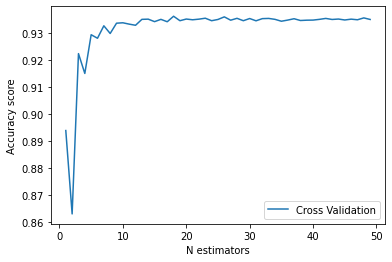

The best performance using using cross validation is: 18 estimators


In [80]:
# used 10 folds, ran for 2 hours still not finished

from sklearn.model_selection import cross_val_score

cv_scores = []

for n in range(1,50):
    rf = RandomForestClassifier(n_estimators = n)
    
    cv_score = np.mean(cross_val_score(rf,X_remainder, y_remainder, cv=5))
    cv_scores.append(cv_score)

plt.figure()
plt.plot(range(1,50), cv_scores, label="Cross Validation")
plt.xlabel('N estimators')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

n = range(1,50)[np.argmax(cv_scores)]
print(f"The best performance using using cross validation is: {n} estimators")

In [81]:
best_rf = RandomForestClassifier(n_estimators=n)
best_rf.fit(X_remainder, y_remainder)
best_rf.score(X_test,y_test)

0.9357745177313157

In [82]:
accuracy_sc.append(best_rf.score(X_test,y_test))
modelling.append('Random Forest')

In [83]:
from sklearn.metrics import confusion_matrix

y_pred = best_rf.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[  51,  527],
       [  29, 8050]], dtype=int64)

In [84]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.64      0.09      0.16       578
           1       0.94      1.00      0.97      8079

    accuracy                           0.94      8657
   macro avg       0.79      0.54      0.56      8657
weighted avg       0.92      0.94      0.91      8657



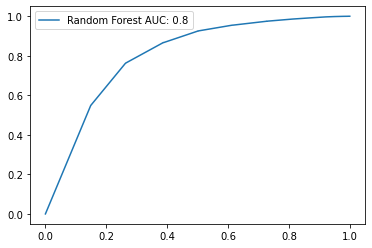

In [85]:
best_rf = RandomForestClassifier(n_estimators=n)
best_rf = best_rf.fit(X_remainder, y_remainder)
y_pred = best_rf.predict_proba(X_test)[:, 1]


rf_fprs_test, rf_tprs_test, thresholds_test = roc_curve(y_test, y_pred)

rf_auc_value = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot(rf_fprs_test, rf_tprs_test, label=f"Random Forest AUC: {round(rf_auc_value,2)}")
plt.legend()
plt.show()

<br>

### Linear SVC

In [86]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

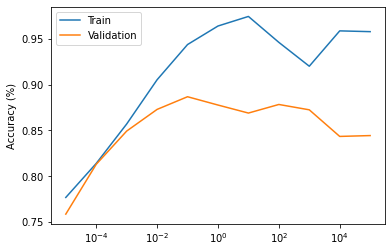

In [87]:
from sklearn.svm import LinearSVC

train_scores = []
test_scores = []
val_scores =[]
C_values = []

for i in range(-5, 6):

    linear_SVC = LinearSVC(C=10**i)

    linear_SVC.fit(X_train, y_train)
    
    C_values.append(10**i)
    train_scores.append(linear_SVC.score(X_train, y_train))
    test_scores.append(linear_SVC.score(X_test, y_test))
    val_scores.append(linear_SVC.score(X_validation, y_validation))

    
plt.figure()
plt.plot(C_values, train_scores, label="Train")
plt.plot(C_values, val_scores, label="Validation")
plt.xscale("log")
plt.legend()
plt.ylabel("Accuracy (%)")
plt.show()

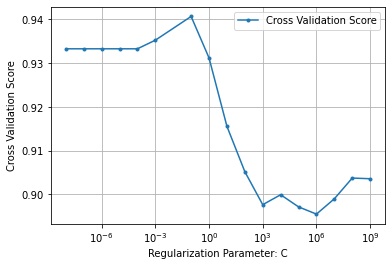

The best model has C =  0.1


In [88]:
from sklearn.model_selection import cross_val_score

cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    linear_SVC = LinearSVC(C=c)
    cv_score = np.mean(cross_val_score(linear_SVC, X_remainder, y_remainder, cv = 10))
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

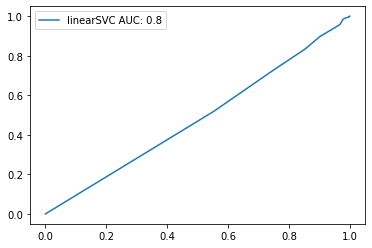

Score on train: 0.9636503658067
Score on test: 0.9394709483654846


In [89]:
best_linear_SVC = LinearSVC(C=C_range[which_max])
best_linear_SVC.fit(X_remainder, y_remainder)

linearSVC_fprs_test, linearSVC_tprs_test, thresholds_test = roc_curve(y_test, y_pred)

linearSVC_auc_value = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot(linearSVC_fprs_test, linearSVC_tprs_test, label=f"linearSVC AUC: {round(rf_auc_value,2)}")
plt.legend()
plt.show()

train_score = best_linear_SVC.score(X_remainder,y_remainder)
test_score = best_linear_SVC.score(X_test, y_test)

print(f'Score on train: {train_score}')
print(f'Score on test: {test_score}')

In [90]:
accuracy_sc.append(test_score)
modelling.append('Linear SVC')

In [91]:
from sklearn.metrics import confusion_matrix

y_pred = best_linear_SVC.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[ 146,  432],
       [  92, 7987]], dtype=int64)

In [92]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.61      0.25      0.36       578
           1       0.95      0.99      0.97      8079

    accuracy                           0.94      8657
   macro avg       0.78      0.62      0.66      8657
weighted avg       0.93      0.94      0.93      8657



<br>
<br>

### Kernel SVM

In [93]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

In [94]:
from sklearn.svm import SVC
my_kernel_SVM = SVC(kernel='sigmoid', max_iter=100000)

my_kernel_SVM.fit(X_remainder,y_remainder)

SVC(kernel='sigmoid', max_iter=100000)

In [95]:
train_score = my_kernel_SVM.score(X_remainder,y_remainder)
test_score = my_kernel_SVM.score(X_test, y_test)

print(f'Score on train: {train_score}')
print(f'Score on test: {test_score}')

Score on train: 0.9080477474008471
Score on test: 0.9056255053713758


In [96]:
accuracy_sc.append(test_score)
modelling.append('Kernel SVM')

In [97]:
from sklearn.metrics import confusion_matrix

y_pred = my_kernel_SVM.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[ 108,  470],
       [ 347, 7732]], dtype=int64)

In [98]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.24      0.19      0.21       578
           1       0.94      0.96      0.95      8079

    accuracy                           0.91      8657
   macro avg       0.59      0.57      0.58      8657
weighted avg       0.90      0.91      0.90      8657



<br>

### Naive Bayes

In [99]:
X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

In [100]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# Instatiate our model
nbmodel = BernoulliNB()
# Fit our model
nbmodel.fit(X_remainder, y_remainder)

nbmodel.predict(X_test)

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [101]:
test_score = nbmodel.score(X_test, y_test)
print(f'Score on test: {test_score}')

Score on test: 0.9120942589811714


In [102]:
accuracy_sc.append(test_score)
modelling.append('Naive Bayes')

In [103]:
from sklearn.metrics import confusion_matrix

y_pred = nbmodel.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[ 171,  407],
       [ 354, 7725]], dtype=int64)

In [104]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.33      0.30      0.31       578
           1       0.95      0.96      0.95      8079

    accuracy                           0.91      8657
   macro avg       0.64      0.63      0.63      8657
weighted avg       0.91      0.91      0.91      8657



<br>

### Word embedding with Neural Network

In [105]:
from sklearn.model_selection import train_test_split

# Taking a chuck for our 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [106]:
reviews_df['stemmed_tokens'] = [my_tokenizer(sentence) for sentence in reviews_df['reviews.text'].values]
reviews_df['stemmed_tokens'] .head(10)

0    [product, far, not, disappoint, children, love...
1    [great, beginn, experienc, person, bought, gif...
2    [inexpens, tablet, use, learn, step, nabi, thr...
3    [ive, fire, hd, 8, two, week, love, tablet, gr...
4    [bought, grand, daughter, come, visit, set, us...
5    [amazon, fire, 8, inch, tablet, perfect, size,...
6    [great, eread, go, nice, light, weight, price,...
7    [gave, christma, gift, inlaw, husband, uncl, l...
8    [great, devic, read, book, like, link, borrow,...
9                    [love, order, book, read, reader]
Name: stemmed_tokens, dtype: object

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # equivalent to .fit(X_train)
sequences = tokenizer.texts_to_sequences(X_train) # equivalent to .transform(X_train)

In [108]:
import tensorflow as tf
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [109]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(sequences, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), padding='post', truncating='post')

In [110]:
X_test.shape

(8657, 496)

In [111]:
y_test.shape

(8657,)

In [112]:
X_train

array([[   1,  144,    8, ...,    0,    0,    0],
       [ 386,  357,  505, ...,    0,    0,    0],
       [  11, 6979,   72, ...,    0,    0,    0],
       ...,
       [   4,   23,    7, ...,    0,    0,    0],
       [   4,   76,   41, ...,    0,    0,    0],
       [ 386,   23,   26, ...,    0,    0,    0]])

In [113]:
X_test

array([[  4, 104,   7, ...,   0,   0,   0],
       [166, 144,   3, ...,   0,   0,   0],
       [875, 107,  14, ...,   0,   0,   0],
       ...,
       [  4,  16, 646, ...,   0,   0,   0],
       [ 22,   1, 164, ...,   0,   0,   0],
       [  9,  74,  40, ...,   0,   0,   0]])

In [114]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [115]:
from gensim.models import Word2Vec

stemmed_tokens = pd.Series(reviews_df['stemmed_tokens']).values
w2v_model = Word2Vec(stemmed_tokens, min_count = 1, size = 1000, workers = 3, window = 3, sg = 1)
words = list(w2v_model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 14094


In [116]:
embedding_dim=16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  layers.Embedding(len(words), embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          225504    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 225,793
Trainable params: 225,793
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2819 - accuracy: 0.8734 - val_loss: 0.2405 - val_accuracy: 0.9332
Epoch 2/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2437 - accuracy: 0.9332 - val_loss: 0.2399 - val_accuracy: 0.9328
Epoch 3/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2429 - accuracy: 0.9332 - val_loss: 0.2353 - val_accuracy: 0.9327
Epoch 4/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2419 - accuracy: 0.9333 - val_loss: 0.2310 - val_accuracy: 0.9332
Epoch 5/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2407 - accuracy: 0.9333 - val_loss: 0.2276 - val_accuracy: 0.9332
Epoch 6/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2392 - accuracy: 0.9333 - val_loss: 0.2356 - val_accuracy: 0.9332
Epoch 7/100
812/812 [==============================] - 6s 7ms/step - loss: 0.2376 - accuracy: 0.9333 - val_loss: 0.2230 - val_accuracy: 0.9332

Epoch 58/100
812/812 [==============================] - 6s 8ms/step - loss: 0.1057 - accuracy: 0.9618 - val_loss: 0.3666 - val_accuracy: 0.9181
Epoch 59/100
812/812 [==============================] - 6s 8ms/step - loss: 0.1040 - accuracy: 0.9630 - val_loss: 0.3722 - val_accuracy: 0.9175
Epoch 60/100
812/812 [==============================] - 6s 8ms/step - loss: 0.1042 - accuracy: 0.9627 - val_loss: 0.3748 - val_accuracy: 0.9169
Epoch 61/100
812/812 [==============================] - 7s 9ms/step - loss: 0.1042 - accuracy: 0.9625 - val_loss: 0.3898 - val_accuracy: 0.9213
Epoch 62/100
812/812 [==============================] - 8s 9ms/step - loss: 0.1019 - accuracy: 0.9643 - val_loss: 0.3953 - val_accuracy: 0.9225
Epoch 63/100
812/812 [==============================] - 7s 9ms/step - loss: 0.1016 - accuracy: 0.9630 - val_loss: 0.3944 - val_accuracy: 0.9179
Epoch 64/100
812/812 [==============================] - 6s 8ms/step - loss: 0.1022 - accuracy: 0.9633 - val_loss: 0.3981 - val_accuracy:

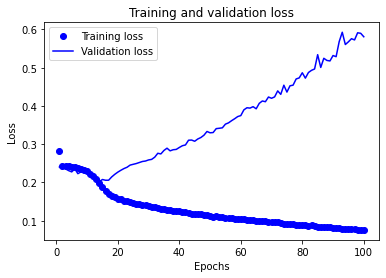

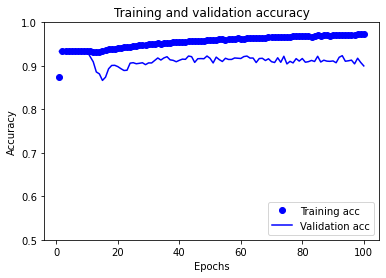

In [118]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

Looking at this result, we can see that the training loss continues to decrease after each epoch. However, the validation loss actually starts to increase. After a certain number of epochs our model begins to overfit to our training data. We can use this plot to determine the number of epochs we want to run our model for. In this example, we would probably stop training our model after about 10 epochs. <br> <br>
In practice, many neural networks will take so long to train that we will never reach this threshold. In these cases, we will train for as long as feasibly possible or until we get results that are satisfactory for our application.

In [119]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=2)
print (score[1])

68/68 - 0s - loss: 0.5809 - accuracy: 0.8998
0.8998498320579529


In [120]:
accuracy_sc.append(score[1])
modelling.append('Tensorflow NN')

<br><br>

### Results

In [121]:
results_df=pd.DataFrame()
results_df['Model']=modelling
results_df['Accuracy Score']=accuracy_sc
results_df

,Model,Accuracy Score
0,Logistic Regression,0.940742
1,K Nearest Neighbor,0.933118
2,Decision Tree,0.933811
3,Random Forest,0.935775
4,Linear SVC,0.939471
5,Kernel SVM,0.905626
6,Naive Bayes,0.912094
7,Tensorflow NN,0.899850


In [122]:
results_df.to_excel("results.xlsx") 

<br><br>

### Predicting if a single review is positive or negative

In [124]:
X = reviews_df['reviews.text']
y = reviews_df['reviews.rating']

X_train, X_validation, X_test, X_remainder, y_train, y_validation, y_test, y_remainder, bagofwords = train_test_split(X,y)

ValueError: not enough values to unpack (expected 9, got 4)

In [128]:
new_review = 'it is slow'
new_corpus = my_tokenizer(new_review)
new_X_test = bagofwords.transform(new_corpus).toarray()
best_log_model = LogisticRegression(C=0.1)
best_log_model.fit(X_remainder,y_remainder)
new_y_pred = best_log_model.predict(new_X_test)
print(new_y_pred)

[1]


it is still detect negative word as positive. why?